# Lecture 5. Topic Models

Natural Language Processing for Law and Social Science<br>
Elliott Ash, ETH Zurich

In [1]:
# set random seed
import numpy as np
np.random.seed(4)

In [7]:
# Setup
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
X = pd.read_pickle('X.pkl').toarray()
X_tfidf = pd.read_pickle('X_tfidf.pkl').toarray()

In [8]:
from gensim.utils import simple_preprocess
text0 = ' '.join(simple_preprocess(df['opinion_text'][0]))
text1 = ' '.join(simple_preprocess(df['opinion_text'][1]))

text1[:1000]

'justice stevens delivered the opinion of the court in most of the united states not including california the minimum price paid to dairy farmers producing raw milk is regulated pursuant to federal marketing orders those orders guarantee uniform price for the producers but through pooling mechanisms require the processors of different classes of dairy products to pay different prices thus for example processors of fluid milk pay premium price part of which goes into an equalization pool that provides partial subsidy for cheese manufacturers who pay net price that is lower than the farmers receive seewest lynn creamery inc healy ed ct the california legislature has adopted similar program to regulate the minimum prices paid by california processors to california producers in the cases before us today out of state producers are challenging the of amendment to that program they present us with two questions whether of the federal agriculture improvement and reform act of stat usc uscs exe

## Principal Component Analysis

In [9]:
#%% Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.06008335, 0.03858287, 0.03146097])

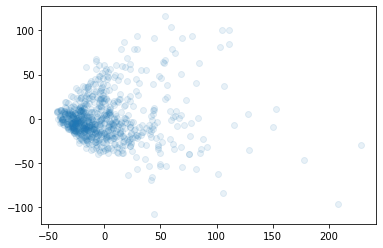

In [10]:
#%% PCA Viz
plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)
plt.show()

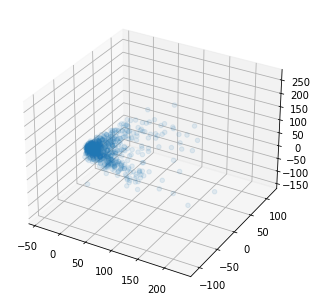

In [11]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [12]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

304

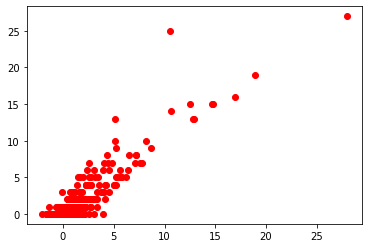

In [13]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plt.plot(Xrestore[0],X[0],'ro')

In [14]:
#%% Incremental PCA
X_mm = np.memmap('X.pkl',shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=1000, n_components=100)

In [15]:
#%% PC Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
Y = df['log_cite_count']
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

0.1927975943615007

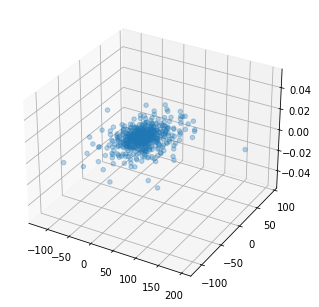

In [16]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xmds[:,0],Xmds[:,1], alpha=.3)

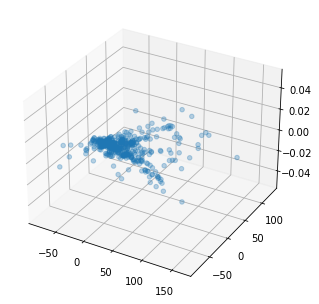

In [17]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xiso[:,0],Xiso[:,1], alpha=.3)

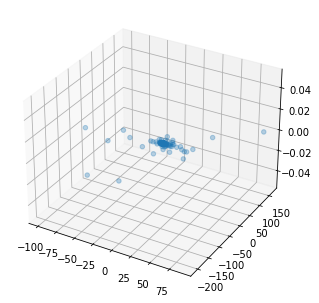

In [18]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=250)
Xtsne = tsne.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xtsne[:,0],Xtsne[:,1], alpha=.3)

# Latent Dirichlet Allocation

For further reference see the material from topic [modeling with gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [19]:
# clean document
from gensim.utils import simple_preprocess
import spacy
from spacy.tokenizer import Tokenizer
from tqdm import tqdm as tq
nlp = spacy.load('en_core_web_sm')
# this is faster and we don't need the whole grammatical parse analysis

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(df['opinion_text'][:100]):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))
print (doc_clean[:10])


# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)
print (len(dictionary))


# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


[['justice', 'ginsburg', 'deliver', 'opinion', 'court'], ['motion', 'federal', 'prisoner', 'postconviction', 'relief', 'u.s.c.', 'subject', 'year', 'time', 'limitation', 'generally', 'run', 'date', 'judgment', 'conviction', 'final', 'p6(1', 'case', 'concern', 'starting', 'date', 'year', 'limitation', 'present', 'narrow', 'recur', 'question', 'court', 'appeal', 'divide', 'defendant', 'federal', 'prosecution', 'take', 'unsuccessful', 'direct', 'appeal', 'judgment', 'conviction', 'petition', 'writ', 'certiorari', 'court', 'judgment', 'final', 'postconviction', 'relief', 'purpose', 'appellate', 'court', 'issue', 'mandate', 'affirm', 'conviction', 'instead', 'date', 'ordinarily', 'day', 'later', 'time', 'file', 'petition', 'certiorari', 'expire'], ['accord', 'court', 'consistent', 'understanding', 'finality', 'context', 'collateral', 'review', 'weight', 'low', 'court', 'authority', 'reject', 'issuance', 'appellate', 'court', 'mandate', 'triggering', 'date', 'purpose', 'start', 'clock', 'yea

[(0,
  [('right', 0.030821323),
   ('u.s.', 0.024385516),
   ('state', 0.022498557),
   ('amendment', 0.018342033),
   ('law', 0.014800088),
   ('clause', 0.014189131),
   ('id.', 0.014117366),
   ('petitioner', 0.012933609),
   ('property', 0.01241243),
   ('case', 0.011110412)]),
 (1,
  [('u.s.', 0.04557176),
   ('law', 0.03148481),
   ('states', 0.03125029),
   ('united', 0.028576534),
   ('case', 0.016954929),
   ('f.3d', 0.015113255),
   ('statute', 0.013535483),
   ('supra', 0.010003846),
   ('state', 0.00936192),
   ('rule', 0.008597425)]),
 (2,
  [('action', 0.020571806),
   ('plaintiff', 0.018989421),
   ('damage', 0.018870277),
   ('delay', 0.013398741),
   ('case', 0.012232274),
   ('act', 0.011112988),
   ('party', 0.009720905),
   ('public', 0.009192562),
   ('subsection', 0.008939614),
   ('agency', 0.008625762)]),
 (3,
  [('arbitration', 0.032783948),
   ('party', 0.024025707),
   ('agreement', 0.018410249),
   ('plan', 0.017929045),
   ('arbitrator', 0.01567549),
   ('c

In [20]:
# to get the topic proportions for a document, use
# the corresponding row from the document-term matrix.
lda[doc_term_matrix[1]]

[(0, 0.021885823),
 (4, 0.04122939),
 (5, 0.7272415),
 (7, 0.08019149),
 (9, 0.12035743)]

In [21]:
# or, for all documents
[lda[d] for d in doc_term_matrix]

[[(0, 0.2972863), (2, 0.29545188), (5, 0.098557495), (7, 0.29619905)],
 [(4, 0.042895693), (5, 0.7353666), (7, 0.083781645), (9, 0.1268848)],
 [(0, 0.53803116), (4, 0.3199892), (7, 0.12490239)],
 [(4, 0.1605504), (5, 0.6446162), (7, 0.15364511)],
 [(0, 0.0500021),
  (1, 0.050000917),
  (2, 0.050005097),
  (3, 0.050006244),
  (4, 0.050001834),
  (5, 0.050004054),
  (6, 0.05000093),
  (7, 0.05000562),
  (8, 0.5499701),
  (9, 0.050003152)],
 [(4, 0.83361405), (6, 0.14586754)],
 [(1, 0.07500969),
  (2, 0.19287065),
  (3, 0.4036697),
  (6, 0.11551997),
  (9, 0.20486203)],
 [(0, 0.6548554), (4, 0.07424502), (8, 0.2417241)],
 [(0, 0.50189215), (1, 0.3199099), (4, 0.053942956), (6, 0.11912454)],
 [(2, 0.23423783), (3, 0.56769794), (6, 0.18178108)],
 [(0, 0.02524599),
  (1, 0.14312583),
  (2, 0.06417279),
  (7, 0.29097372),
  (8, 0.47015005)],
 [(2, 0.2323049), (3, 0.44620624), (5, 0.09619941), (9, 0.2169526)],
 [(3, 0.9823467)],
 [(0, 0.080151804),
  (2, 0.26846516),
  (7, 0.20803837),
  (8, 0

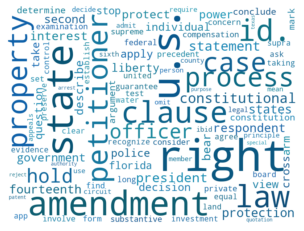

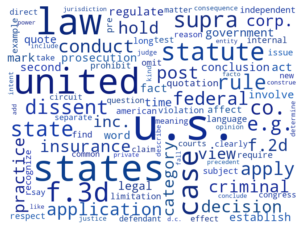

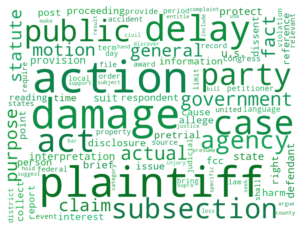

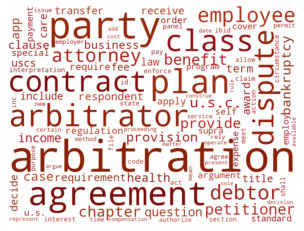

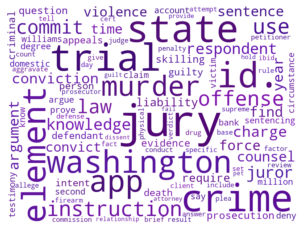

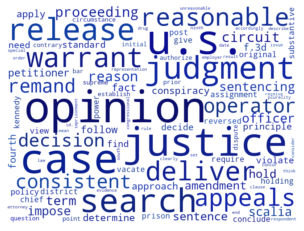

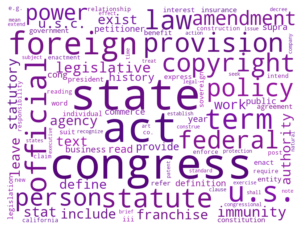

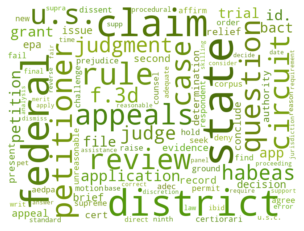

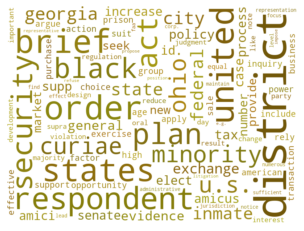

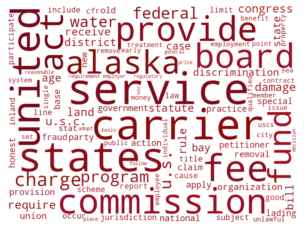

In [22]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [26]:
# pyLDAvis, for more details, refer to https://github.com/bmabey/pyLDAvis
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.129336 -0.059852       1        1  16.113399
1      0.005835  0.047660       2        1  14.149362
6     -0.134241  0.073049       3        1  10.866699
0      0.033152  0.079600       4        1  10.360377
4      0.167172 -0.043155       5        1  10.325487
2     -0.038932 -0.005183       6        1   9.067277
9     -0.134648 -0.026870       7        1   8.414564
3     -0.062019  0.015721       8        1   8.308417
5      0.088634  0.102182       9        1   6.586681
8     -0.054288 -0.183151      10        1   5.807737, topic_info=            Term         Freq        Total Category  logprob  loglift
10      district  1079.000000  1079.000000  Default  30.0000  30.0000
741  arbitration   464.000000   464.000000  Default  29.0000  29.0000
74        united  1271.000000  1271.000000  Default  28.0000  28.0000
689         jury   433.000000   433.000000  Default  27.0000  27.0000
313       states  1439.000000  1439.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
38          u.s.   100.051240  2740.804204  Topic10  -4.5727  -0.4643
202     evidence    67.183361   487.713204  Topic10  -4.9709   0.8637
70         state    91.788717  2699.172167  Topic10  -4.6589  -0.5352
42          case    57.932831  1683.581521  Topic10  -5.1191  -0.5234
82           id.    56.511978   961.141751  Topic10  -5.1439   0.0123

[547 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
599       5  0.014062     accident
599       6  0.871816     accident
599       8  0.098431     accident
714       1  0.249699  accordingly
714       2  0.011890  accordingly
...     ...       ...          ...
226       6  0.023324         year
226       7  0.081635         year
226       8  0.084551         year
226       9  0.008747         year
226      10  0.043733         year

[2778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 7, 1, 5, 3, 10, 4, 6, 9])

Using Mallet to calculate coherence scores for different number of topics to automatically determine the best number of topics


In [ ]:
# you need gensim version <= 3.8.3 for this to work
import gensim
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

mallet_path = '~/mallet-2.0.8/bin/mallet'
scores = []
for num_topics in range(2, 20, 2):
    print (num_topics)
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=doc_clean, corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    scores.append((num_topics, coherence.get_coherence()))
pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])



## Singular Value Decomposition (SVD)

For further reference for this and the following section see [here](https://github.com/fastai/course-nlp/blob/219d0c217bd83339e21471d31cd787e86d6ec0a0/2-svd-nmf-topic-modeling.ipynb).

In [28]:
from scipy import linalg

X = pd.read_pickle('X.pkl').todense()
vec = pd.read_pickle('vec-3grams-1.pkl')
vocab = np.array(vec.get_feature_names())
vocab[400:500]


array(['department', 'described', 'designed', 'despite', 'detention',
       'determination', 'determine', 'determined', 'determining',
       'different', 'difficult', 'direct', 'directly', 'discharge',
       'discretion', 'discrimination', 'dismissed', 'dispute', 'dissent',
       'dissenting', 'distinction', 'district', 'district court',
       'districts', 'doctrine', 'domestic', 'doubt', 'drug', 'drugs',
       'duty', 'earlier', 'ed supp', 'education', 'effect', 'effective',
       'election', 'element', 'elements', 'emphasis', 'emphasis added',
       'employee', 'employees', 'employer', 'employment', 'enacted',
       'end', 'enforce', 'enforcement', 'entered', 'entitled', 'epa',
       'equal', 'equitable', 'erisa', 'error', 'establish', 'established',
       'et', 'et seq', 'event', 'evidence', 'ex', 'example', 'exception',
       'executive', 'exercise', 'existing', 'explained', 'express',
       'expressly', 'extent', 'fact', 'factor', 'factors', 'facts',
       'factual',

In [29]:
U, s, Vh = linalg.svd(X, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(768, 768) (768,) (768, 1000)


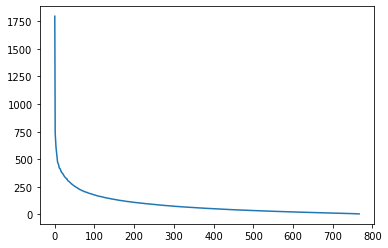

In [30]:
plt.plot(s)

In [31]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

show_topics(Vh[:10])

['924 debtor securities trust fourth amendment equitable summary judgment waiver',
 'state trial evidence jury counsel defendant death sentence',
 'state state law commerce pre property state court immunity districts',
 'district district court jurisdiction claims claim rule courts habeas',
 'district right amendment school rights minority speech districts',
 'right military jurisdiction habeas war courts rights amendment',
 'rule right tax claim action party arbitration property',
 'school government public tax religious schools program commission',
 'commission tax rate party military judge war plan',
 'counsel rate service evidence right cost act epa']

## Non-negative Matrix Factorization (NMF) 

In [32]:
from sklearn import decomposition

clf = decomposition.NMF(n_components=10, random_state=1)

W1 = clf.fit_transform(X)
H1 = clf.components_

show_topics(H1)

/usr/local/lib/python3.8/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

['act congress statute agency authority regulations use health',
 'trial evidence counsel rule defendant petitioner judge jury',
 'state new state court courts state law tax claim clause',
 'district minority districts plan district court voting majority political',
 'right amendment rights bear second state constitutional clause',
 'military war habeas commission government jurisdiction courts cases',
 'death sentence penalty jury sentencing death penalty crime offense',
 'school public government religious speech schools program private',
 'rate service cost rates commission elements local market',
 'action claims claim jurisdiction rule parties district district court']

## Author Topic Model

In [33]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

df = df.reset_index()
df['id'] = df.index
author2doc = df[:100][['authorship','id']]
author2doc = author2doc.groupby('authorship').apply(lambda x: list(x['id'])).to_dict()
author2doc

{'ALITO': [14, 29, 30, 33, 39, 43],
 'BREYER': [6, 10, 15, 19, 26, 36, 54, 73, 74, 80, 81, 95],
 'GINSBURG': [0, 7, 9, 11, 18, 25, 27, 52, 68, 84, 86, 90, 96, 97],
 'KENNEDY': [3, 4, 16, 21, 34, 40, 42, 48, 62, 64, 65, 76, 85, 87],
 "O'CONNOR": [2, 49, 59, 66, 75, 83, 88],
 'REHNQUIST': [55, 56, 70, 79, 94],
 'ROBERTS': [12, 35, 44],
 'SCALIA': [20, 23, 28, 37, 41, 45, 51, 61, 63, 82, 98],
 'SOUTER': [5, 47, 53, 67, 72, 78, 91, 92],
 'STEVENS': [1, 17, 31, 32, 38, 46, 57, 60, 71, 93],
 'THOMAS': [8, 13, 22, 24, 50, 58, 69, 77, 89, 99]}

In [34]:
model = AuthorTopicModel(
        doc_term_matrix, author2doc=author2doc, id2word=dictionary, num_topics=10)

# For each author list topic distribution
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]
author_vecs[:2]

[[(0, 0.10000000000000002),
  (1, 0.10000000000000002),
  (2, 0.10000000000000002),
  (3, 0.10000000000000002),
  (4, 0.10000000000000002),
  (5, 0.10000000000000002),
  (6, 0.10000000000000002),
  (7, 0.10000000000000002),
  (8, 0.10000000000000002),
  (9, 0.10000000000000002)],
 [(0, 0.10000000000000002),
  (1, 0.10000000000000002),
  (2, 0.10000000000000002),
  (3, 0.10000000000000002),
  (4, 0.10000000000000002),
  (5, 0.10000000000000002),
  (6, 0.10000000000000002),
  (7, 0.10000000000000002),
  (8, 0.10000000000000002),
  (9, 0.10000000000000002)]]